In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [2]:
columns = ['unit_number','time_in_cycles','setting_1','setting_2','TRA','T2','T24','T30','T50','P2','P15','P30','Nf',
           'Nc','epr','Ps30','phi','NRf','NRc','BPR','farB','htBleed','Nf_dmd','PCNfR_dmd','W31','W32' ]

train_data_processed = []
for idx in range(1, 5):
    train_data = pd.read_csv(rf"train_FD00{idx}.txt",sep=" ",header=None)
    train_data.drop(columns=[26,27],inplace=True)

    train_data.columns = columns
    train_data.drop(columns=['Nf_dmd','PCNfR_dmd','P2','T2','TRA','farB','epr'],inplace=True)
    train_data['RUL'] =  train_data['time_in_cycles'] / train_data.groupby('unit_number')['time_in_cycles'].transform('max') 

    train_data.drop(columns=['unit_number', 'setting_1', 'setting_2'],inplace=True)

    train_data_processed.append(train_data)
    print(f"Processed train_FD00{idx}.txt, number of rows: {train_data.shape[0]}")
train_data_processed = pd.concat(train_data_processed, ignore_index=True)

Processed train_FD001.txt, number of rows: 20631
Processed train_FD002.txt, number of rows: 53759
Processed train_FD003.txt, number of rows: 24720
Processed train_FD004.txt, number of rows: 61249


In [3]:
test_data_processed = []

for idx in range(1,5):

    test_data_rul = pd.read_csv(rf"RUL_FD00{idx}.txt",sep=" ",header=None)
    test_data = pd.read_csv(rf"test_FD00{idx}.txt",sep=" ",header=None)


    test_data.drop(columns=[26,27],inplace=True)
    columns = ['unit_number','time_in_cycles','setting_1','setting_2','TRA','T2','T24','T30','T50','P2','P15','P30','Nf',
            'Nc','epr','Ps30','phi','NRf','NRc','BPR','farB','htBleed','Nf_dmd','PCNfR_dmd','W31','W32' ]

    test_data.columns = columns
    test_data.drop(columns=['Nf_dmd','PCNfR_dmd','P2','T2','TRA','farB','epr'],inplace=True)

    eol = []
    for un in test_data['unit_number'].unique():
        temp_data = test_data[test_data['unit_number'] == un]
        eol_temp = test_data_rul.iloc[un-1].values[0]
        eol_temp_list = [eol_temp for i in range(len(temp_data))]

        eol.extend(eol_temp_list)


    test_data['RUL'] = test_data['time_in_cycles'].values / (test_data.groupby('unit_number')['time_in_cycles'].transform('max').values + eol)  
    test_data.drop(columns=['unit_number', 'setting_1', 'setting_2'],inplace=True)

    test_data_processed.append(test_data)

    print(f"Processed test_FD00{idx}.txt, number of rows: {test_data.shape[0]}")
test_data_processed = pd.concat(test_data_processed, ignore_index=True)


Processed test_FD001.txt, number of rows: 13096
Processed test_FD002.txt, number of rows: 33991
Processed test_FD003.txt, number of rows: 16596
Processed test_FD004.txt, number of rows: 41214


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# 1. Dataset class
class RULDataset(Dataset):
    def __init__(self, dataframe):
        self.X = dataframe.drop(columns=["RUL"]).values.astype(np.float32)
        self.y = dataframe["RUL"].values.astype(np.float32).reshape(-1, 1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx]), torch.tensor(self.y[idx])

# 2. Neural Network model
class RULModel(nn.Module):
    def __init__(self, input_dim):
        super(RULModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(),

            nn.Linear(256, 256),
            nn.LeakyReLU(),

            nn.Linear(256, 256),
            nn.LeakyReLU(),

            nn.Linear(256, 1)
        )

    def forward(self, x):
        return self.model(x)



In [6]:
# Normalize the features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
features = train_data_processed.drop(columns=['RUL'])
scaled_features = scaler.fit_transform(features)
train_data_processed.loc[:, features.columns] = scaled_features

# Normalize test data using the same scaler
test_features = test_data_processed.drop(columns=['RUL'])
test_scaled_features = scaler.transform(test_features)
test_data_processed.loc[:, test_features.columns] = test_scaled_features

C:\Users\rsree\AppData\Local\Temp\ipykernel_9960\1275619669.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-1.46438155 -1.45241094 -1.44044032 ...  1.55221385  1.56418447
  1.57615508]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  train_data_processed.loc[:, features.columns] = scaled_features
C:\Users\rsree\AppData\Local\Temp\ipykernel_9960\1275619669.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 1.00902172  1.00902172  0.94454996 ...  1.10572936 -0.76395171
 -0.89289524]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  train_data_processed.loc[:, features.columns] = scaled_features
C:\Users\rsree\AppData\Local\Temp\ipykernel_9960\1275619669.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error

In [7]:
# 4. Dataset & Dataloader
dataset = RULDataset(train_data_processed)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Create TEST Dataset and DataLoader
test_dataset = RULDataset(test_data_processed)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 5. Training Setup
input_dim = train_data_processed.shape[1] - 1  # Exclude RUL
model = RULModel(input_dim).to(device)

# ###########################################################Load the model if it exists
# model.load_state_dict(torch.load("rul_ann_model.pth"))
# model.to(device)
# model.eval()
# ##########################################################

criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

def evaluate_model(model, test_loader):
    # 3. Run inference
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            all_preds.append(outputs.cpu().numpy())
            all_targets.append(y_batch.numpy())

    # 4. Calculate MSE
    preds = np.vstack(all_preds)
    targets = np.vstack(all_targets)
    mse = mean_squared_error(targets, preds)
    return mse

In [8]:
# 6. Training Loop
best_mse = float("inf")
epochs = 50
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in dataloader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Forward pass

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    val_mse = evaluate_model(model, test_loader)
    if val_mse < best_mse:
        best_mse = val_mse
        torch.save(model.state_dict(), "rul_ann_model.pth")

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(dataloader):.4f}, Test MSE: {val_mse:.4f}")

Epoch [1/50], Loss: 0.0085, Test MSE: 0.0058
Epoch [2/50], Loss: 0.0053, Test MSE: 0.0055
Epoch [3/50], Loss: 0.0051, Test MSE: 0.0055
Epoch [4/50], Loss: 0.0049, Test MSE: 0.0053
Epoch [5/50], Loss: 0.0048, Test MSE: 0.0060
Epoch [6/50], Loss: 0.0048, Test MSE: 0.0056
Epoch [7/50], Loss: 0.0047, Test MSE: 0.0054
Epoch [8/50], Loss: 0.0047, Test MSE: 0.0050
Epoch [9/50], Loss: 0.0046, Test MSE: 0.0051
Epoch [10/50], Loss: 0.0046, Test MSE: 0.0057
Epoch [11/50], Loss: 0.0046, Test MSE: 0.0051
Epoch [12/50], Loss: 0.0045, Test MSE: 0.0055
Epoch [13/50], Loss: 0.0045, Test MSE: 0.0050
Epoch [14/50], Loss: 0.0045, Test MSE: 0.0052
Epoch [15/50], Loss: 0.0045, Test MSE: 0.0055
Epoch [16/50], Loss: 0.0045, Test MSE: 0.0049
Epoch [17/50], Loss: 0.0045, Test MSE: 0.0054
Epoch [18/50], Loss: 0.0045, Test MSE: 0.0050
Epoch [19/50], Loss: 0.0044, Test MSE: 0.0053
Epoch [20/50], Loss: 0.0044, Test MSE: 0.0050
Epoch [21/50], Loss: 0.0044, Test MSE: 0.0052
Epoch [22/50], Loss: 0.0044, Test MSE: 0.00

# Visualize Test Results

In [19]:

idx=4

test_data_rul = pd.read_csv(rf"RUL_FD00{idx}.txt",sep=" ",header=None)
test_data = pd.read_csv(rf"test_FD00{idx}.txt",sep=" ",header=None)


test_data.drop(columns=[26,27],inplace=True)
columns = ['unit_number','time_in_cycles','setting_1','setting_2','TRA','T2','T24','T30','T50','P2','P15','P30','Nf',
        'Nc','epr','Ps30','phi','NRf','NRc','BPR','farB','htBleed','Nf_dmd','PCNfR_dmd','W31','W32' ]

test_data.columns = columns
test_data.drop(columns=['Nf_dmd','PCNfR_dmd','P2','T2','TRA','farB','epr'],inplace=True)

eol = []
for un in test_data['unit_number'].unique():
    temp_data = test_data[test_data['unit_number'] == un]
    eol_temp = test_data_rul.iloc[un-1].values[0]
    eol_temp_list = [eol_temp for i in range(len(temp_data))]

    eol.extend(eol_temp_list)


test_data['RUL'] = test_data['time_in_cycles'].values / (test_data.groupby('unit_number')['time_in_cycles'].transform('max').values + eol) 
# test_data.drop(columns=['unit_number', 'setting_1', 'setting_2'],inplace=True)




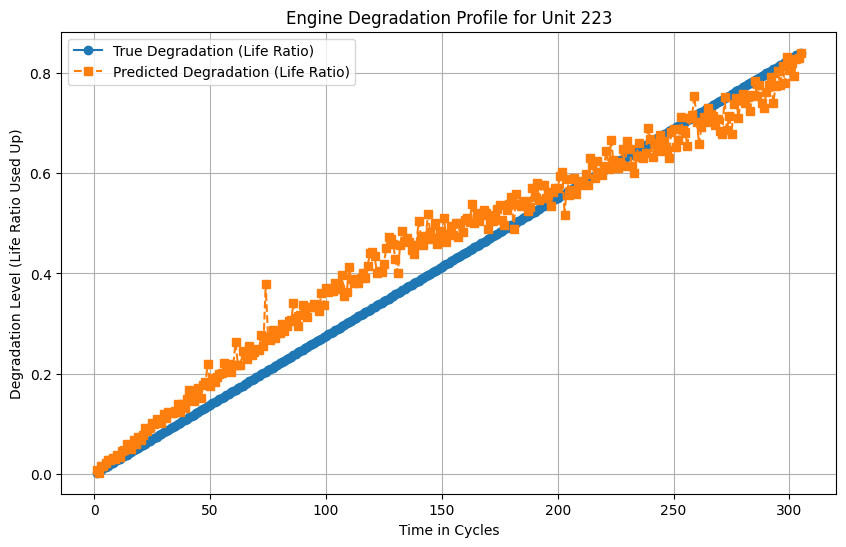

In [26]:
# --- This cell is for visualizing the results for a single engine ---

# Select an example unit number to visualize
unit_id = 223
unit_data = test_data[test_data['unit_number'] == unit_id]

# The 'RUL' column already contains the "life used up" ratio (0 to 1)
true_life_ratio = unit_data['RUL'].values

# Prepare the features for prediction
# Note: We are using the original 'test_data' dataframe which still has the unit_number
# before it was dropped for the main training/evaluation.
X_for_prediction = scaler.transform(unit_data.drop(columns=['unit_number','setting_1','setting_2','RUL']))
X_for_prediction_tensor = torch.tensor(X_for_prediction).float().to(device)

# Get the model's predictions
model.eval()
with torch.no_grad():
    predicted_life_ratio = model(X_for_prediction_tensor).cpu().numpy().flatten()

# --- Plotting the Corrected Graph ---

plt.figure(figsize=(10, 6))

# Plot the life ratio directly, so it goes UP from 0 to 1
plt.plot(unit_data['time_in_cycles'], true_life_ratio, label='True Degradation (Life Ratio)', marker='o', linestyle='-')
plt.plot(unit_data['time_in_cycles'], predicted_life_ratio, label='Predicted Degradation (Life Ratio)', marker='s', linestyle='--')

plt.xlabel('Time in Cycles')
plt.ylabel('Degradation Level (Life Ratio Used Up)') # Updated Y-axis label
plt.title(f'Engine Degradation Profile for Unit {unit_id}') # Updated Title
plt.legend()
plt.grid(True)
plt.show()

In [11]:
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np

# Make sure the model is in evaluation mode
model.eval()

# Load the best performing model that was saved during training
model.load_state_dict(torch.load("rul_ann_model.pth"))
model.to(device)

all_preds = []
all_targets = []

# We don't need to calculate gradients for evaluation
with torch.no_grad():
    # Loop through the test data loader
    for X_batch, y_batch in test_loader:
        # Move data to the same device as the model (CPU or GPU)
        X_batch = X_batch.to(device)
        
        # Get the model's predictions
        outputs = model(X_batch)
        
        # Add the predictions and true targets to our lists
        all_preds.append(outputs.cpu().numpy())
        all_targets.append(y_batch.numpy())

# Combine the lists of predictions and targets into single numpy arrays
preds = np.vstack(all_preds)
targets = np.vstack(all_targets)

# --- Calculate and Print the Metrics ---

# Calculate Mean Squared Error (MSE) and Root Mean Squared Error (RMSE)
mse = mean_squared_error(targets, preds)
rmse = np.sqrt(mse)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(targets, preds)

# Calculate R-squared (Coefficient of Determination)
r2 = r2_score(targets, preds)

print(f"--- Model Performance on Test Data ---")
print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")
print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"R-squared (R²) Score: {r2:.6f}")

C:\Users\rsree\AppData\Local\Temp\ipykernel_9960\115161934.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("rul_ann_model.pth"))


--- Model Performance on Test Data ---
Mean Squared Error (MSE): 0.004948
Root Mean Squared Error (RMSE): 0.070341
Mean Absolute Error (MAE): 0.051121
R-squared (R²) Score: 0.913000


In [12]:
# --- A More Stable Custom Accuracy ---
# Using a fixed absolute tolerance instead of a percentage

# Define your tolerance. For RUL from 0 to 1, a value like 0.05 is a good start.
# This means we count a prediction as "correct" if it's within 0.05 of the true RUL.
absolute_tolerance = 0.10

# Assuming 'preds' and 'targets' are your numpy arrays of predictions and true values
absolute_errors = np.abs(preds - targets)

# Check which predictions are within the fixed tolerance
within_tolerance_fixed = absolute_errors < absolute_tolerance

# Calculate the percentage of "correct" predictions
accuracy_fixed = np.mean(within_tolerance_fixed) * 100

print(f"\n--- Custom Accuracy Metric ---")
print(f"Accuracy with fixed tolerance of ±{absolute_tolerance}: {accuracy_fixed:.2f}%")


--- Custom Accuracy Metric ---
Accuracy with fixed tolerance of ±0.1: 84.82%
